In [109]:
from MieSppForce import  green_func, frenel, dipoles, force
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

In [110]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

In [111]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 110
dist = 2
a_angle = np.pi/4
angle = 25*np.pi/180
STOP = 45
point = [0,0,dist+R]
z0 = point[2]
wls=np.linspace(400,1100,100)
phase = -np.pi/2

k0 = lambda wl: 2*np.pi/wl/1e-9
omega = lambda wl: 2*np.pi*c_const/wl/1e-9

In [112]:

STOP=45

F_x = np.empty((len(wls), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)

Fy_pxmz = np.empty(len(wls))
Fy_pzmx = np.empty(len(wls))
Fx_pymz = np.empty(len(wls))
Fx_pzmy = np.empty(len(wls))

F_x_pm_mp_1  = np.empty(len(wls))
F_x_pm_mp_2 = np.empty(len(wls))
F_y_pm_mp_1 = np.empty(len(wls))
F_y_pm_mp_2 = np.empty(len(wls))

P,M = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)

def AlphaE(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[0]
def AlphaH(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[1]

AlphaEE = AlphaE(R, eps_Si)
AlphaHH = AlphaH(R, eps_Si)

dxGExz = np.empty(len(wls), dtype=complex)
dxGHxz = np.empty_like(dxGExz)
dyGEyz = np.empty_like(dxGExz)
dyGHyz = np.empty_like(dxGExz) 


dxrotGHyz= np.empty(len(wls), dtype=complex)
dxrotGHzy= np.empty(len(wls), dtype=complex)
dyrotGHxz= np.empty(len(wls), dtype=complex)
dyrotGHzx= np.empty(len(wls), dtype=complex)

for i in tqdm(range(len(wls))):
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    dyrotGE, dyrotGH = green_func.dy_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    dxrotGE, dxrotGH = green_func.dx_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGE,dxGH = green_func.dx_green_E_H(wls[i], point[2], eps_Au, STOP)
    dyGE,dyGH = green_func.dy_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGExz[i] = dxGE[0,2]
    dxGHxz[i] = dxGH[0,2]
    dyGEyz[i] = dyGE[1,2]
    dyGHyz[i] = dyGH[1,2]
    
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    dxrotGHyz[i], dxrotGHzy[i] = dxrotGH[1,2], dxrotGH[2,1]
    dyrotGHxz[i], dyrotGHzx[i] = dyrotGH[0,2], dyrotGH[2,0]
    
   
    Fx_pymz_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2])  + k0(wls[i])**3/(12 * np.pi )) * np.real(p[1].conj()*m[2])

    Fx_pzmy_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1]) - k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[1])
    
    F_x_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2]) ) * np.real(p[1].conj()*m[2])
    
    F_x_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1])) * np.real(p[2].conj() * m[1])
        
    Fy_pxmz_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])  - k0(wls[i])**3/(12 * np.pi )) * np.real(p[0].conj()*m[2])

    Fy_pzmx_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) + k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[0])
    
    F_y_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])) * np.real(p[0].conj()*m[2])
    
    F_y_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) ) * np.real(p[2].conj() * m[0])

    Fy_pxmz[i] = Fy_pxmz_exact
    Fy_pzmx[i] = Fy_pzmx_exact
    Fx_pymz[i] = Fx_pymz_exact
    Fx_pzmy[i] = Fx_pzmy_exact
    
    F_x_pm_mp_1[i] = F_x_pm_mp_1_i
    F_x_pm_mp_2[i] = F_x_pm_mp_2_i
    F_y_pm_mp_1[i] = F_y_pm_mp_1_i
    F_y_pm_mp_2[i] = F_y_pm_mp_2_i
        

 21%|██        | 21/100 [00:15<00:57,  1.38it/s]/Users/semyon_b/git/SPP_ANALYTICAL/.venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:449: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
 39%|███▉      | 39/100 [00:30<00:53,  1.14it/s]/Users/semyon_b/git/SPP_ANALYTICAL/.venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:446: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [113]:
STOP=1
P_no_spp,M_no_spp = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)
dxGExz_no_spp = np.empty(len(wls), dtype=complex)
dxGHxz_no_spp = np.empty_like(dxGExz_no_spp)
dyGEyz_no_spp = np.empty_like(dxGExz_no_spp)
dyGHyz_no_spp = np.empty_like(dxGExz_no_spp) 


F_x_no_spp = np.empty((len(wls), 8))
F_y_no_spp = np.empty_like(F_x_no_spp)
F_z_no_spp = np.empty_like(F_y_no_spp)



dxrotGHyz_no_spp= np.empty(len(wls), dtype=complex)
dxrotGHzy_no_spp= np.empty(len(wls), dtype=complex)
dyrotGHxz_no_spp= np.empty(len(wls), dtype=complex)
dyrotGHzx_no_spp= np.empty(len(wls), dtype=complex)


F_x_pm_mp_1_no_spp  = np.empty(len(wls))
F_x_pm_mp_2_no_spp = np.empty(len(wls))
F_y_pm_mp_1_no_spp = np.empty(len(wls))
F_y_pm_mp_2_no_spp = np.empty(len(wls))

for i in tqdm(range(len(wls))):
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x_no_spp [i,:] = f[0]
    F_y_no_spp [i,:] = f[1]
    F_z_no_spp [i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P_no_spp[i,:],M_no_spp[i,:]=p,m
    
    dxGE,dxGH = green_func.dx_green_E_H(wls[i], point[2], eps_Au, STOP)
    dyGE,dyGH = green_func.dy_green_E_H(wls[i], point[2], eps_Au, STOP)
    dyrotGE, dyrotGH = green_func.dy_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    dxrotGE, dxrotGH = green_func.dx_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    
    
    dxGExz_no_spp[i] = dxGE[0,2]
    dxGHxz_no_spp[i] = dxGH[0,2]
    dyGEyz_no_spp[i] = dyGE[1,2]
    dyGHyz_no_spp[i] = dyGH[1,2]
    
    dxrotGHyz_no_spp [i], dxrotGHzy_no_spp [i] = dxrotGH[1,2], dxrotGH[2,1]
    dyrotGHxz_no_spp [i], dyrotGHzx_no_spp [i] = dyrotGH[0,2], dyrotGH[2,0]
    
    F_x_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2]) ) * np.real(p[1].conj()*m[2])
    
    F_x_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1])) * np.real(p[2].conj() * m[1])
    
    F_y_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])) * np.real(p[0].conj()*m[2])
    
    F_y_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) ) * np.real(p[2].conj() * m[0])
    
    F_x_pm_mp_1_no_spp[i] = F_x_pm_mp_1_i
    F_x_pm_mp_2_no_spp[i] = F_x_pm_mp_2_i
    F_y_pm_mp_1_no_spp[i] = F_y_pm_mp_1_i
    F_y_pm_mp_2_no_spp[i] = F_y_pm_mp_2_i

        

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


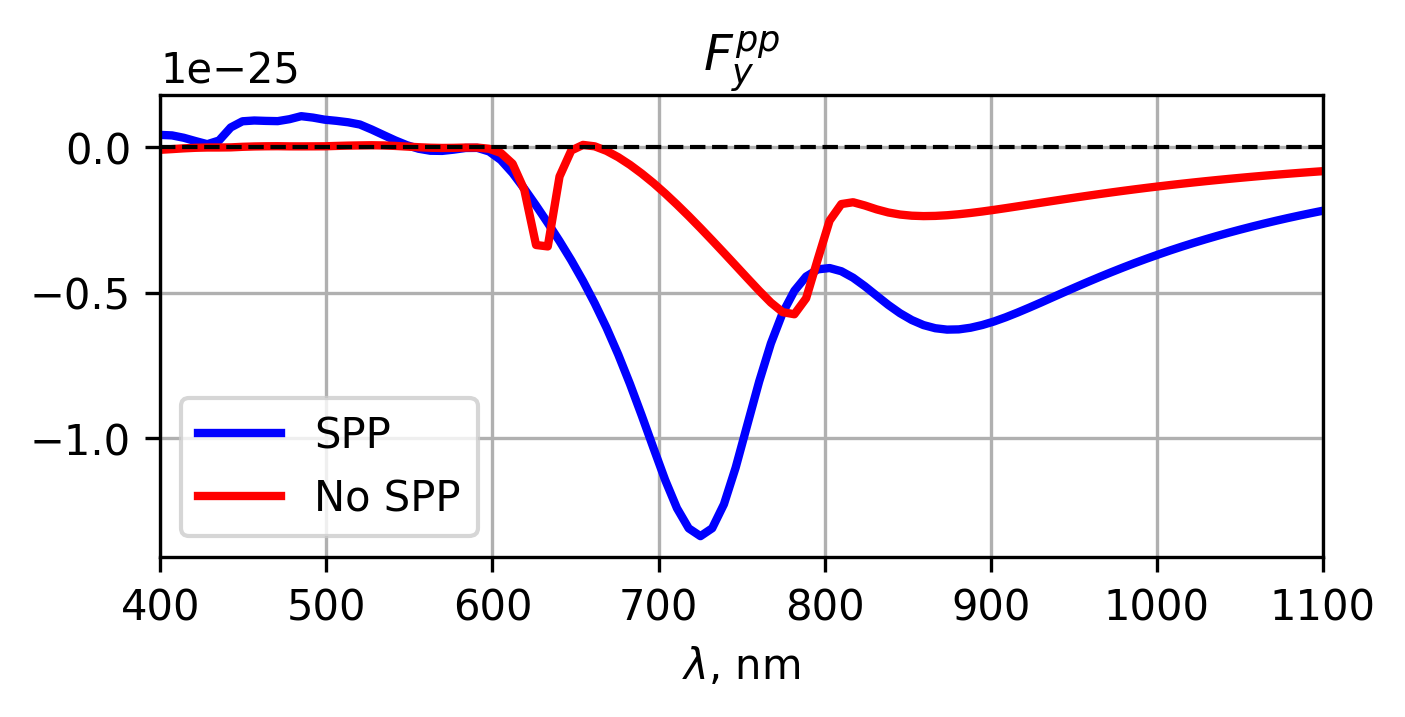

In [118]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('$F_y^{pp}$')
plt.plot(wls, F_x[:,2], label='SPP', c='b', lw=2)
plt.plot(wls, F_x_no_spp[:,2], label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

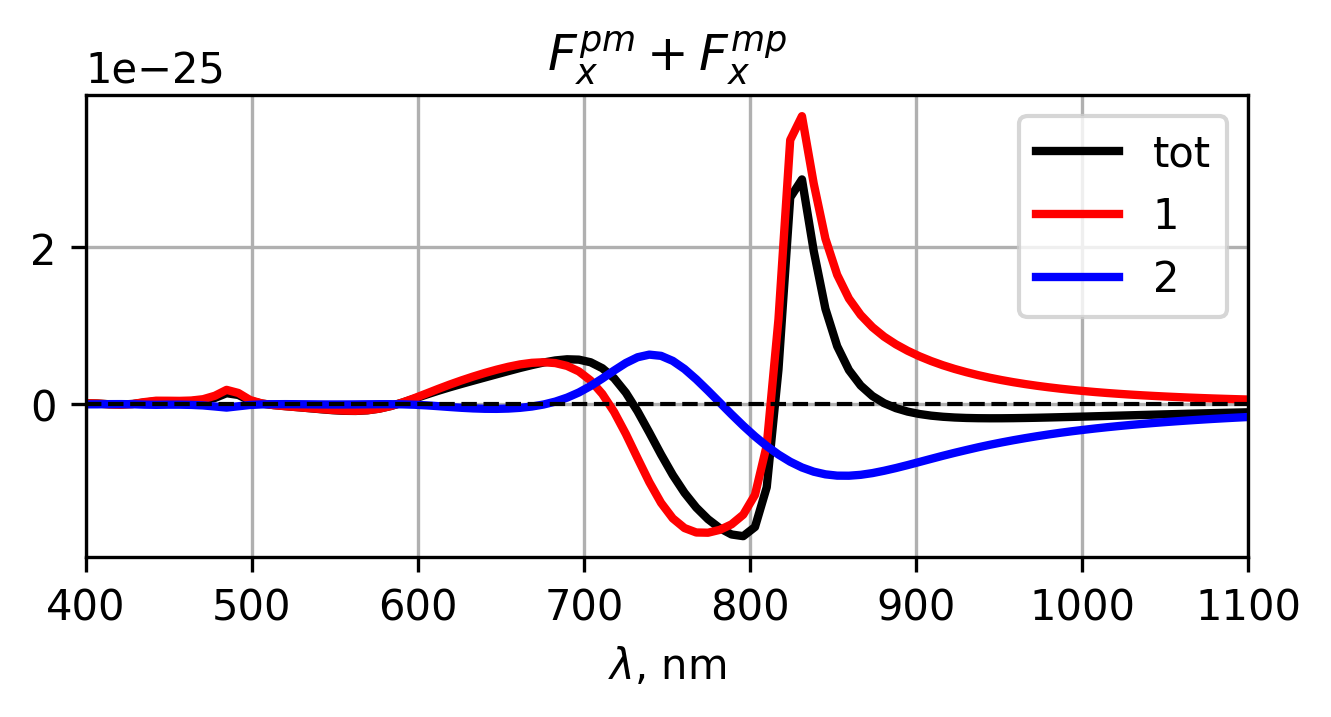

In [62]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('$F_x^{pm}+F_x^{mp}$')
plt.plot(wls, F_x[:,3]+F_x[:,6], label='tot', c='black', lw=2)
plt.plot(wls, F_x_pm_mp_1, label='1', c='r', lw=2)
plt.plot(wls, F_x_pm_mp_2, label='2', c='b', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

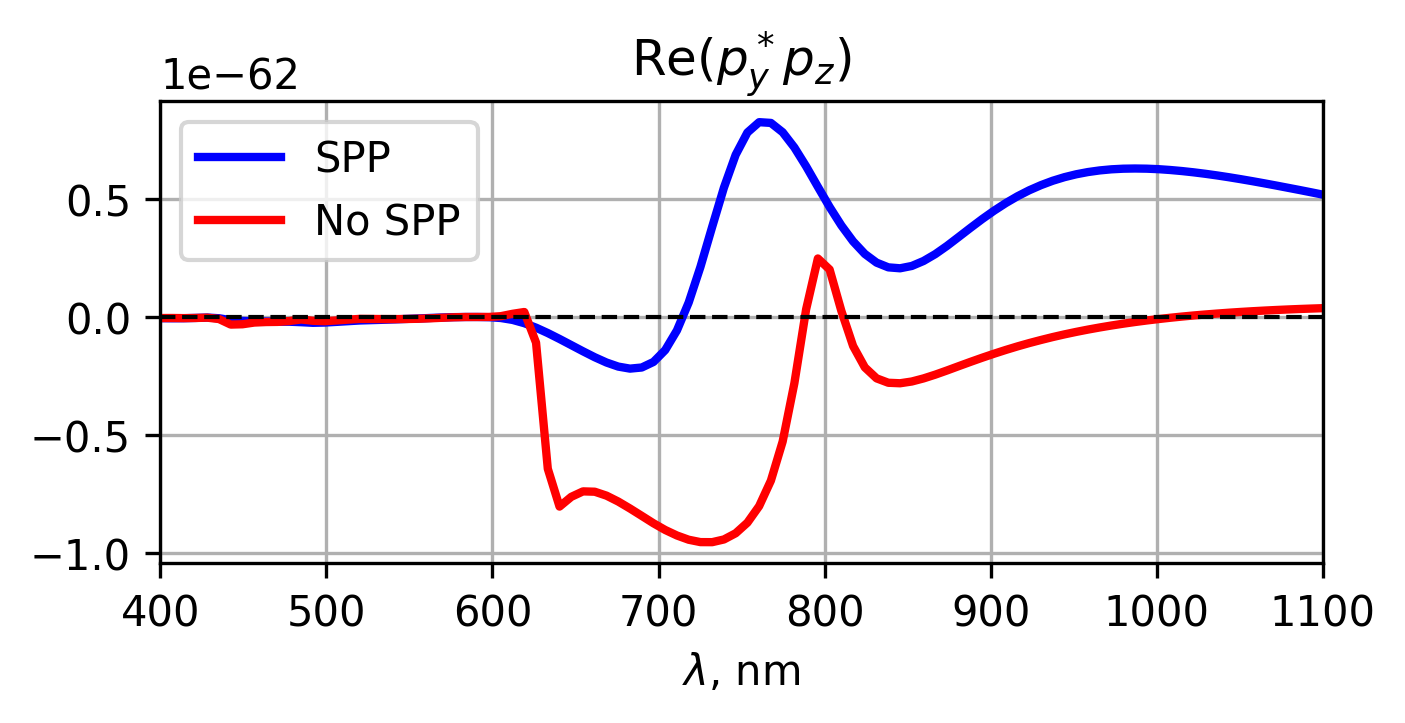

In [121]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('Re($p_y^* p_z$)')
plt.plot(wls, np.imag(P[:,1].conj() * P[:,2] ), label='SPP', c='b', lw=2)
plt.plot(wls, np.imag(P_no_spp[:,1].conj() * P_no_spp[:,2] ), label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

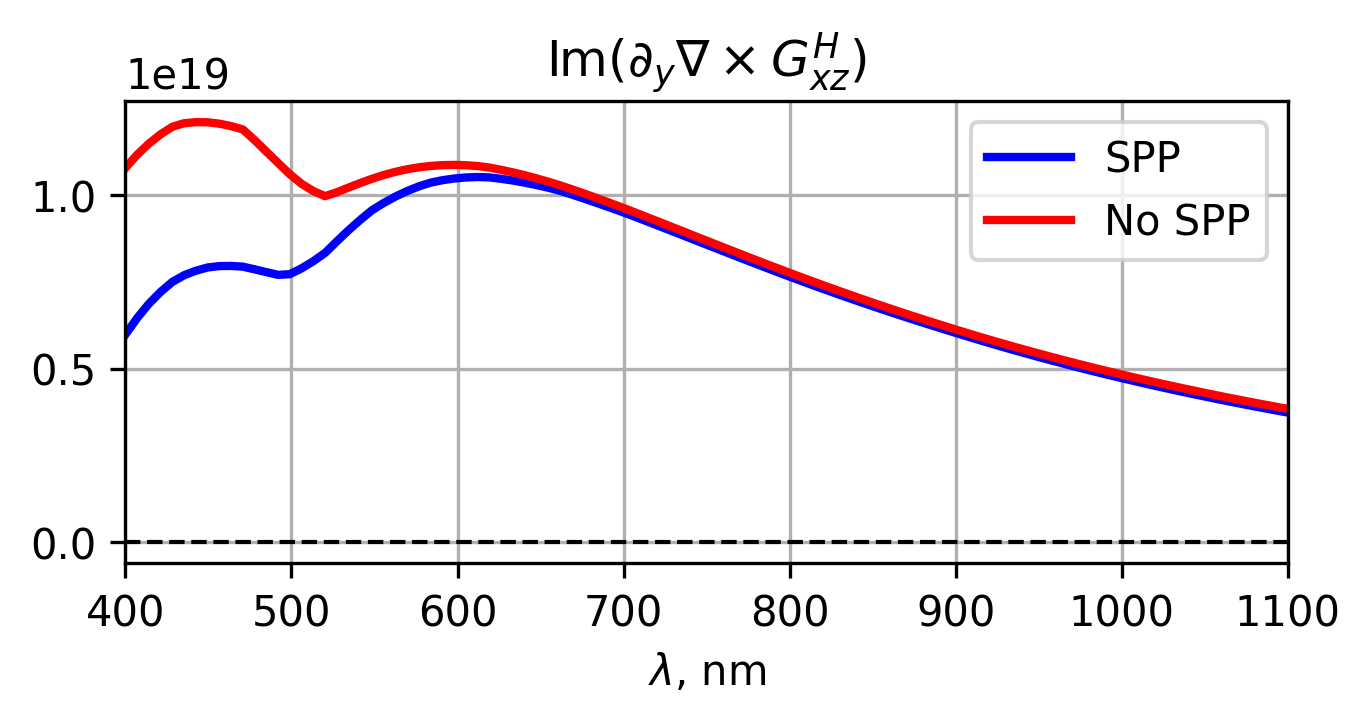

In [87]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('Im($\partial_y \\nabla \\times G^H_{xz}$)')
plt.plot(wls, np.imag(dyrotGHxz ), label='SPP', c='b', lw=2)
plt.plot(wls, np.imag(dyrotGHxz_no_spp ), label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

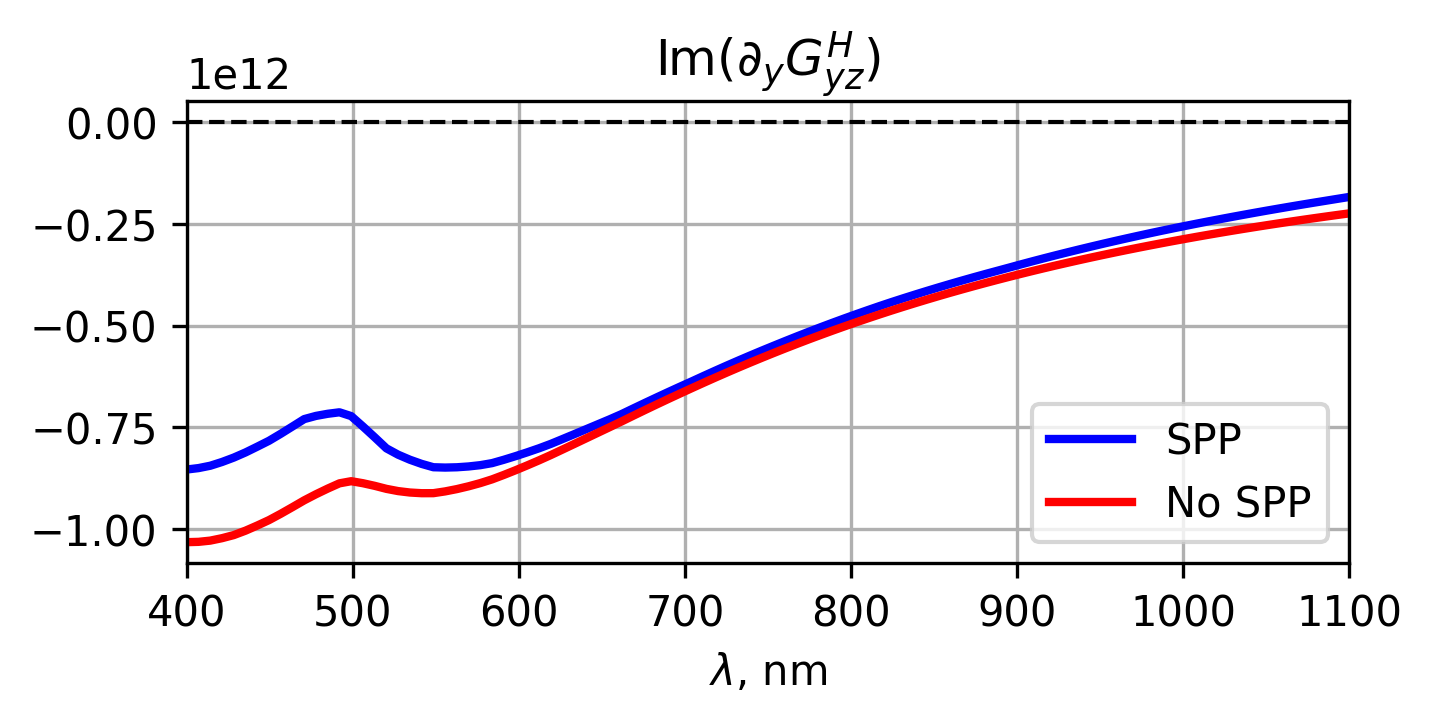

In [44]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('Im($\partial_y G^H_{yz}$)')
plt.plot(wls, np.imag(dyGHyz ), label='SPP', c='b', lw=2)
plt.plot(wls, np.imag(dyGHyz_no_spp ), label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

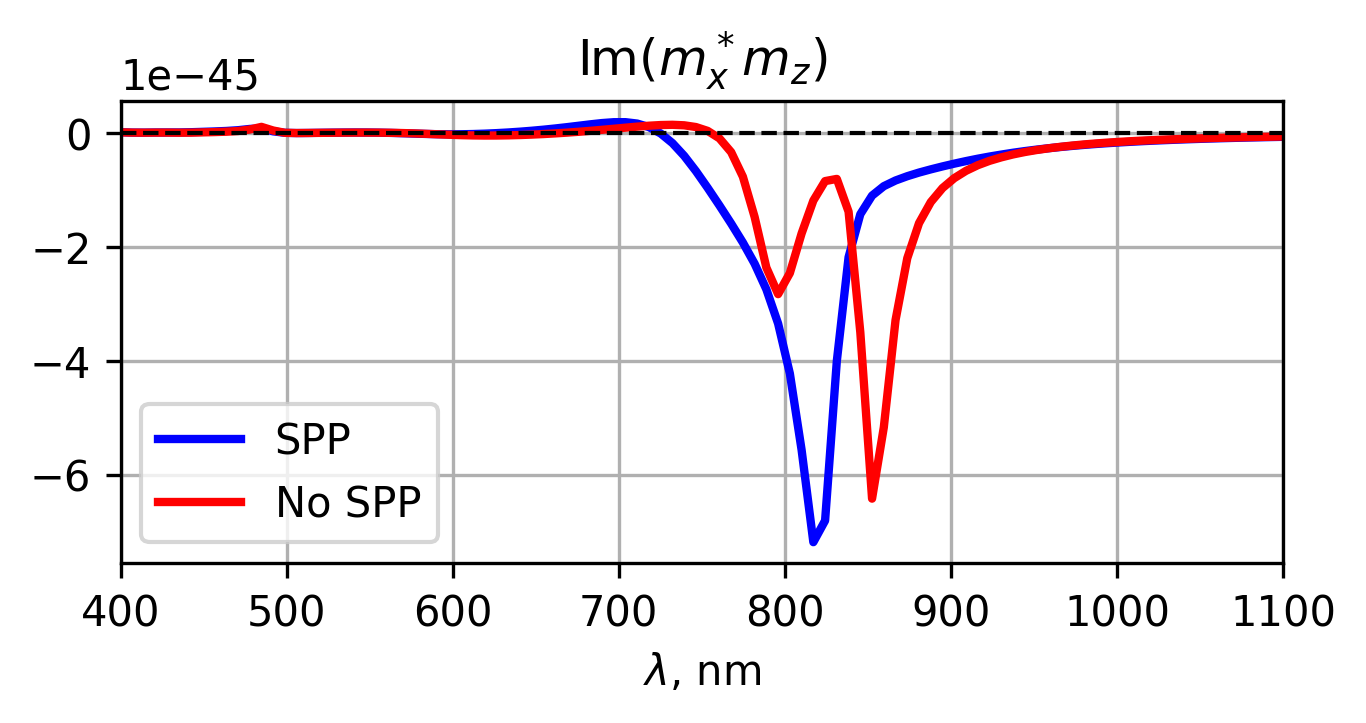

In [49]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('Im($m_x^* m_z$)')
plt.plot(wls, np.imag(M[:,0].conj() * M[:,2] ), label='SPP', c='b', lw=2)
plt.plot(wls, np.imag(M_no_spp[:,0].conj() * M_no_spp[:,2] ), label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

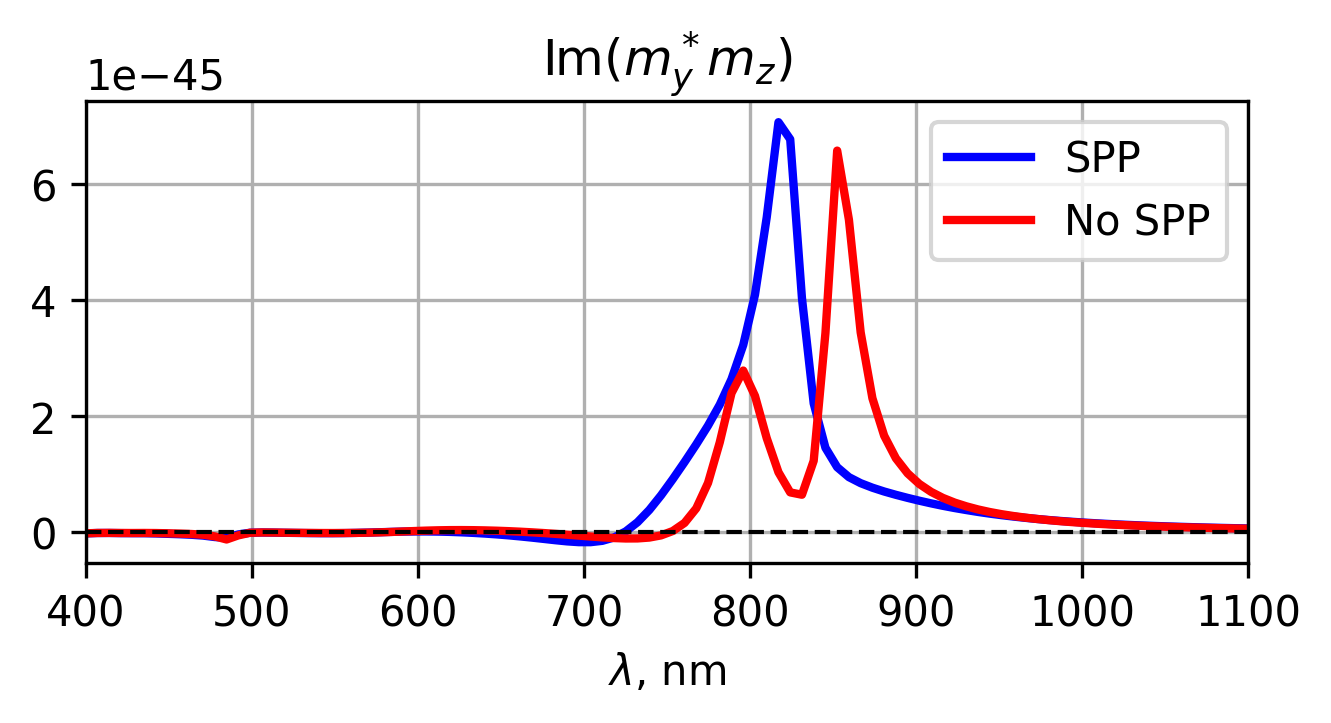

In [50]:
plt.figure(figsize=(5,2), dpi=300)
plt.title('Im($m_y^* m_z$)')
plt.plot(wls, np.imag(M[:,1].conj() * M[:,2] ), label='SPP', c='b', lw=2)
plt.plot(wls, np.imag(M_no_spp[:,1].conj() * M_no_spp[:,2] ), label='No SPP', c='r', lw=2)
plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\lambda$, nm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [3]:
def get_directivity(wl, P,M, eps_Au):
    px,py,pz = P
    mx, my,mz = M
    ka = -1j*np.sqrt(1/(eps_Au(wl)+1))
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))
    I = lambda phi:  np.abs((mx/c_const+1j*ka*py)*np.sin(phi) + (my/c_const - 1j*ka*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return  lambda phi: 2 * np.pi * I(phi) / Imax
    


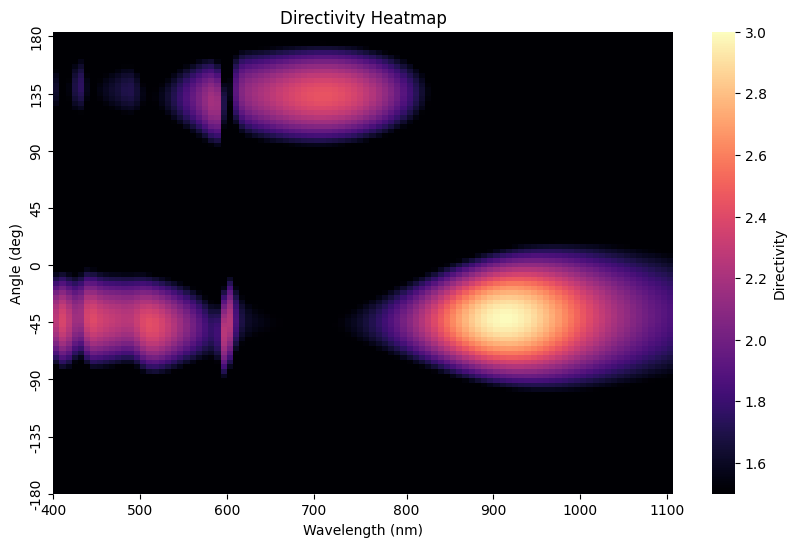

In [104]:
import seaborn as sns

PHI = np.linspace(-np.pi, np.pi, 100)

directivity = np.empty((len(PHI), len(wls)))
for wl_idx, wl in enumerate(wls):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P[wl_idx,:], M[wl_idx,:], eps_Au)
        directivity[angle_idx, wl_idx] = D(PHI[angle_idx])

num_ticks=10
num_ticksy =9
plt.figure(figsize=(10, 6))
ax = sns.heatmap(directivity, cmap='magma', vmax=3, vmin=1.5, cbar_kws={'label': 'Directivity'})
ax.invert_yaxis()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Angle (deg)')

plt.yticks(
    ticks=np.linspace(0, len(PHI) - 1, 9),
    labels=np.arange(-180, 181, 45)
)

xticks_nm = np.arange(400, 1101, 100)
xtick_positions = [np.argmin(np.abs(wls - x)) for x in xticks_nm]
plt.xticks(ticks=xtick_positions, labels=xticks_nm)

plt.title('Directivity Heatmap')
plt.show()

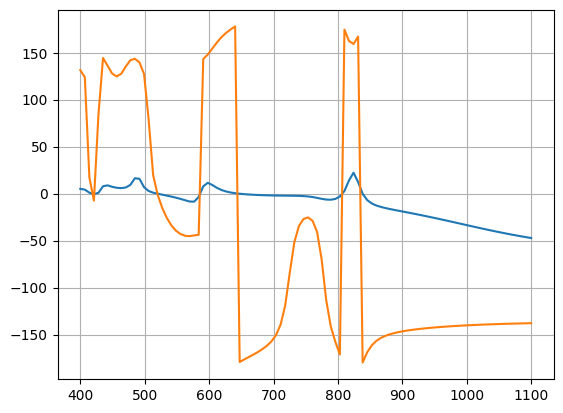

In [119]:
angles = np.arctan2(F_y[:,0], F_x[:,0])

angles_no_sc = np.arctan2(F_y[:,0], F_x[:,0]-F_x[:,1]-F_x[:,4])

plt.plot(wls, angles*180/np.pi, label='Angle')
plt.plot(wls, angles_no_sc*180/np.pi, label='Angle')
plt.grid()

In [99]:
phii = np.pi/4
ind_phii = np.argmin(np.abs(PHI - phii))
wlss = 900
ind_wlss = np.argmin(np.abs(wls - wlss))
print(directivity[ind_phii, ind_wlss])


0.2639628443662863


C:\Users\borod\AppData\Local\Temp\ipykernel_9572\2178394787.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


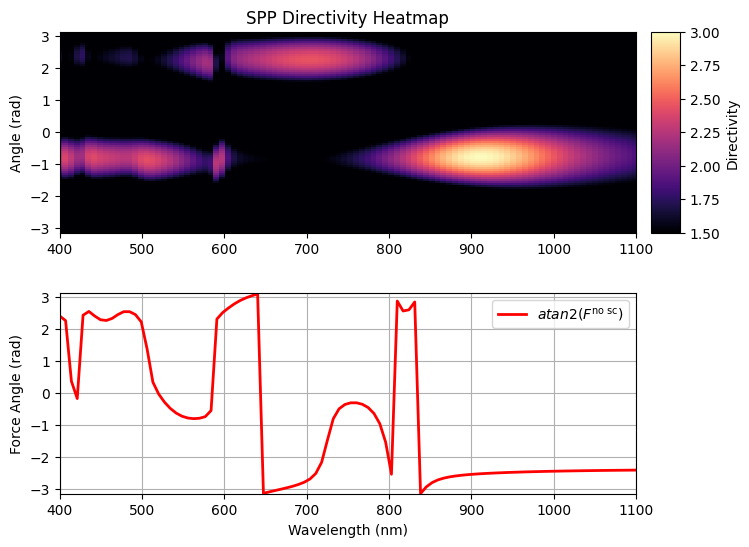

In [183]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


# Создание фигуры и макета
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# Верхний график (heatmap)
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(wls, PHI, directivity, cmap='magma', vmax=3, vmin=1.5)


ax_top.set_xlim(wls[0], wls[-1])
ax_top.set_ylim(np.pi, -np.pi)
ax_top.invert_yaxis()

# Подписи и оформление
ax_top.set_ylabel('Angle (rad)')
ax_top.set_title('SPP Directivity Heatmap')

# Colorbar
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Directivity')


angles_no_sc = np.arctan2( F_y[:,2] + F_y[:,3] + F_y[:,5] + F_y[:,6] + F_y[:,7], F_x[:,2]+F_x[:,3]+F_x[:,6]+F_x[:,7])

angles_no_sc_e1 = np.arctan2( F_y[:,2] , F_x[:,2])

angles_no_sc_m1 = np.arctan2( F_y[:,5] , F_x[:,5])

angles_no_sc_e2m2 = np.arctan2( F_y[:,3] +  F_y[:,6] , F_x[:,3]+ F_x[:,6])


angles_no_sc_cross = np.arctan2( F_y[:,7] , F_x[:,7])


# Нижний график (углы)
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)
#ax_bottom.plot(wls, angles , label='Angle', color='#1f77b4', linewidth=2)
ax_bottom.plot(wls, angles_no_sc, label='$atan2(F^{\\text{no sc}})$', color='r', linewidth=2)
# ax_bottom.plot(wls, angles_no_sc_e1, label='$F^{e1}$', color='b', linewidth=2)

# ax_bottom.plot(wls, angles_no_sc_m1, label='$F^{m1}$', color='r', linewidth=2)

# ax_bottom.plot(wls, angles_no_sc_e2m2, label='$F^{e2+m2}$', color='g', linewidth=2)

# ax_bottom.plot(wls, angles_no_sc_cross, label='$F^{\\times}$', color='purple', linewidth=2)

# Границы по данным
ax_bottom.set_xlim(wls[0], wls[-1])
ax_bottom.set_ylim(-np.pi, np.pi)

# Подписи
ax_bottom.set_xlabel('Wavelength (nm)')
ax_bottom.set_ylabel('Force Angle (rad)')
ax_bottom.grid(True)
ax_bottom.legend()

plt.tight_layout()
plt.savefig('directivity_heatmap_force_angle.png', dpi=300)
plt.show()


In [62]:
sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\borod\AppData\Local\Temp\ipykernel_9572\2075925555.py:1: SyntaxWarning: invalid escape sequence '\s'
  sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')


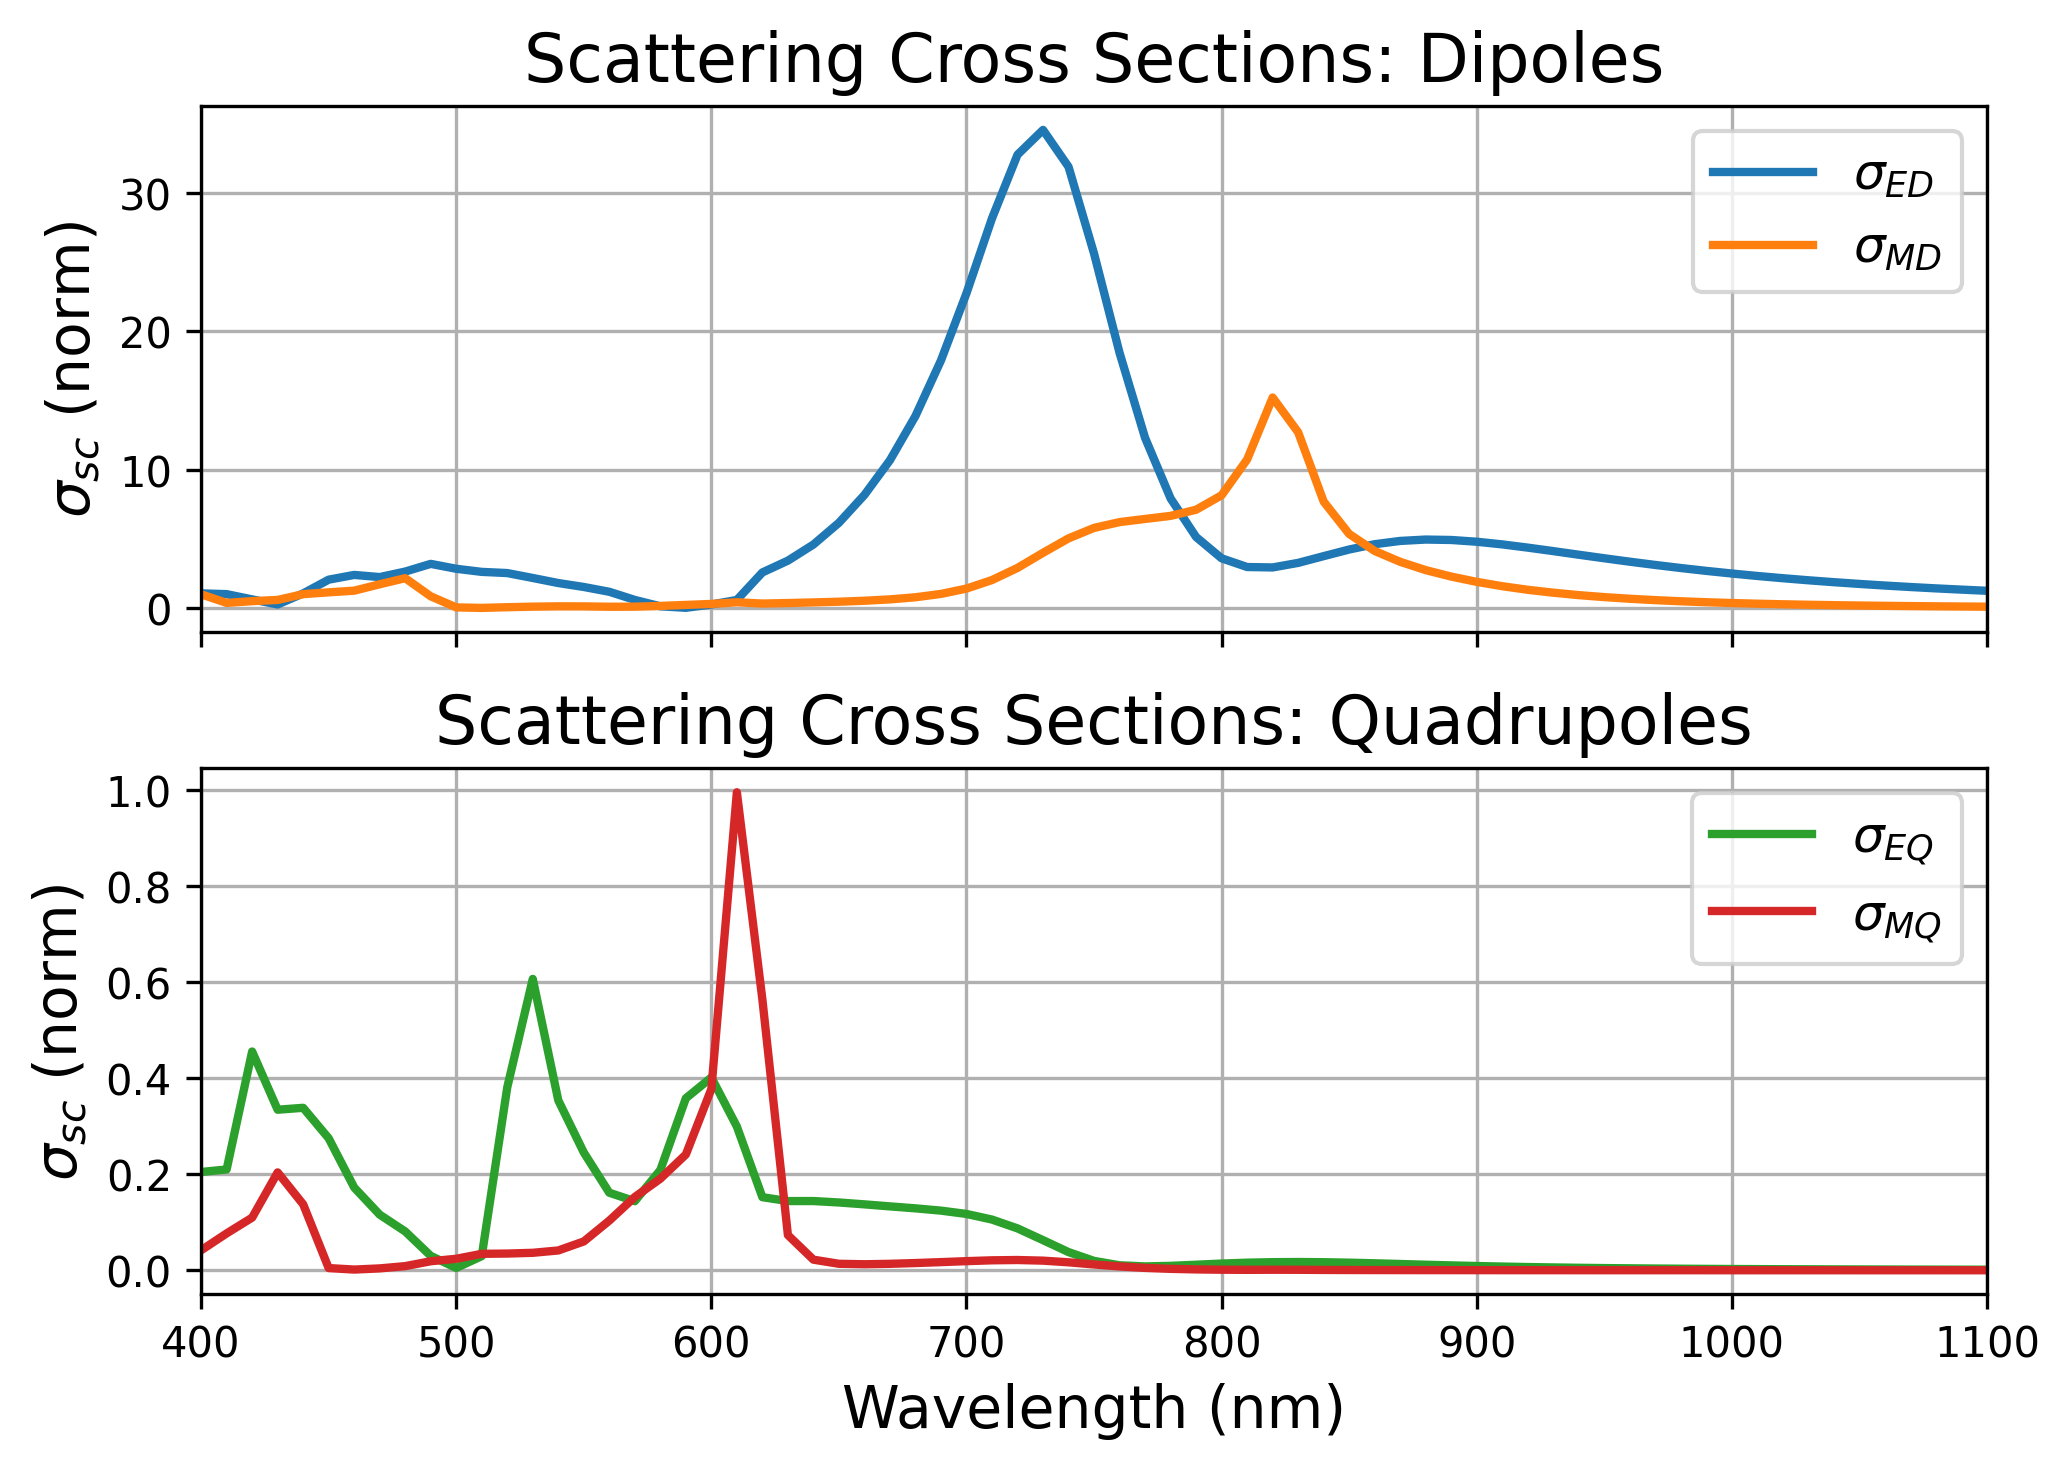

In [168]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1], label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4')
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 2], label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e')
ax1.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_title('Scattering Cross Sections: Dipoles', fontsize=16)

plt.xlim(sigma_sc[0, 0], sigma_sc[-1, 0])

# Второй график: EQ и MQ
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 3], label='$\\sigma_{EQ}$', linewidth=2, color='#2ca02c')
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 4], label='$\\sigma_{MQ}$', linewidth=2, color='#d62728')
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.set_title('Scattering Cross Sections: Quadrupoles', fontsize=16)

plt.tight_layout()
plt.savefig('scattering_cross_sections_from_wl.pdf', dpi=300)
plt.show()


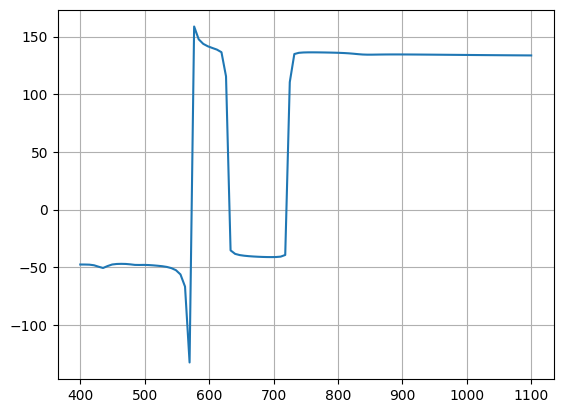

In [61]:
angles_e1 = np.arctan2(F_y[:,5], F_x[:,5])

plt.plot(wls, angles_e1*180/np.pi, label='Angles e1')
plt.grid()

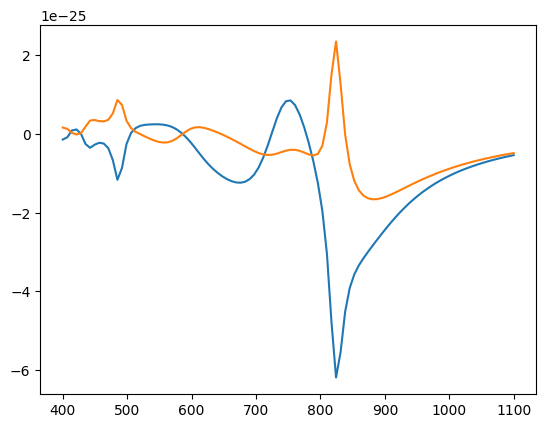

In [ ]:
plt.plot(wls, F_x[:,0]-F_x[:,1]-F_x[:,4])
plt.plot(wls, F_y[:,0] )

In [92]:
Rs = np.linspace(40, 180, 100)
wl = 800
STOP = 45
angle = 25*np.pi/180

a_angle = np.pi/4

phase = -np.pi/2

F_x_from_R = np.empty((len(Rs), 8))
F_y_from_R = np.empty_like(F_x_from_R)
F_z_from_R = np.empty_like(F_x_from_R)

P_from_R,M_from_R = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)


for i in tqdm(range(len(Rs))):
    point = [0,0,dist+Rs[i]]
    f =  force.F(wl, eps_Au, point, Rs[i], eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x_from_R[i,:] = f[0]
    F_y_from_R[i,:] = f[1]
    F_z_from_R[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, Rs[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
   
    p,m = p[:,0],m[:,0]
    P_from_R[i,:],M_from_R[i,:]=p,m
    
    

PHI = np.linspace(-np.pi, np.pi, 100)

directivityR = np.empty((len(PHI), len(Rs)))
for R_idx, R_i in enumerate(Rs):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P_from_R[R_idx,:], M_from_R[R_idx,:], eps_Au)
        directivityR[angle_idx, R_idx] = D(PHI[angle_idx])

        

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


In [ ]:
import seaborn as sns




# num_ticks=10
# num_ticksy =9
# plt.figure(figsize=(10, 6))
# ax = sns.heatmap(directivityR, cmap='magma', vmax=3, vmin=1.5, cbar_kws={'label': 'Directivity'})
# ax.invert_yaxis()
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Angle (deg)')

# plt.yticks(
#     ticks=np.linspace(0, len(PHI) - 1, 9),
#     labels=np.arange(-180, 181, 45)
# )

# xticks_nm = np.linspace(40, 200, 9, dtype=int)
# xtick_positions = [np.argmin(np.abs(Rs - x)) for x in xticks_nm]
# plt.xticks(ticks=xtick_positions, labels=xticks_nm)

# plt.title('Directivity Heatmap')
# plt.show()

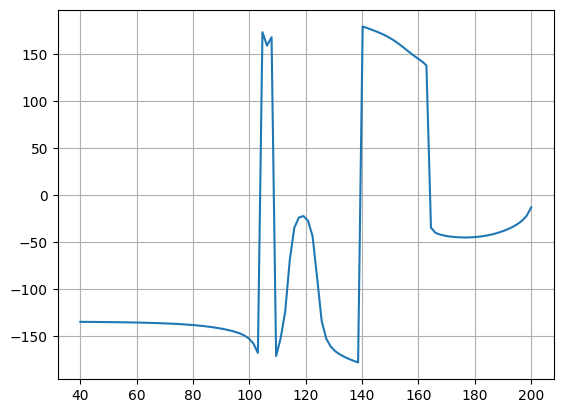

In [ ]:
#angles = np.arctan2(F_y[:,0], F_x[:,0])

angles_no_sc_from_R = np.arctan2(F_y_from_R[:,0], F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4])

#plt.plot(wls, angles*180/np.pi, label='Angle')
plt.plot(Rs, angles_no_sc_from_R*180/np.pi, label='Angle')
plt.grid()

/var/folders/rm/jp69z42j5kv7gm1yn340dwx80000gn/T/ipykernel_23165/876462470.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


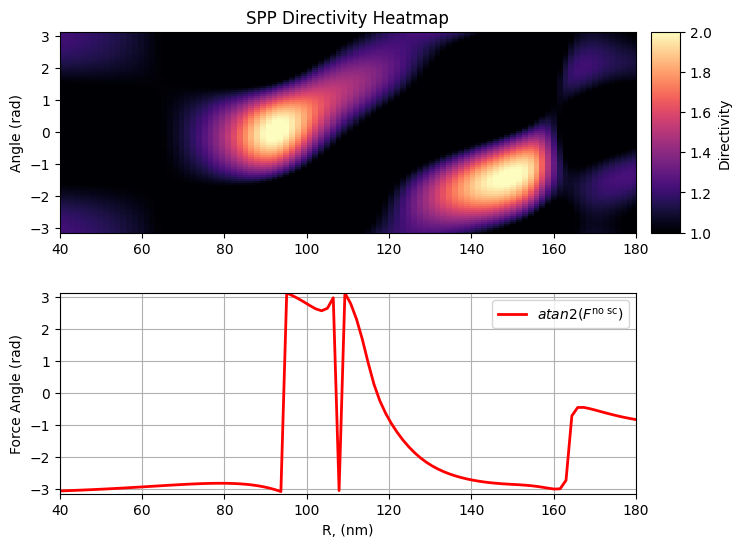

In [129]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


# Создание фигуры и макета
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# Верхний график (heatmap)
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(Rs, PHI, directivityR, cmap='magma', vmax=2, vmin=1)


ax_top.set_xlim(wls[0], wls[-1])
ax_top.set_ylim(-np.pi, np.pi)
#ax_top.invert_yaxis()

# Подписи и оформление
ax_top.set_ylabel('Angle (rad)')
ax_top.set_title('SPP Directivity Heatmap')

# Colorbar
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Directivity')


angles_no_sc_from_R = np.arctan2(F_y_from_R[:,0], F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4])


# Нижний график (углы)
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

#angles_no_sc_from_R+=np.pi



ax_bottom.plot(Rs, angles_no_sc_from_R, label='$atan2(F^{\\text{no sc}})$', color='r', linewidth=2)

# Границы по данным
ax_bottom.set_xlim(Rs[0], Rs[-1])
ax_bottom.set_ylim(-np.pi, np.pi)

# Подписи
ax_bottom.set_xlabel('R, (nm)')
ax_bottom.set_ylabel('Force Angle (rad)')
ax_bottom.grid(True)
ax_bottom.legend()

plt.tight_layout()
#plt.savefig('directivity_heatmap_force_angle.png', dpi=300)
plt.show()


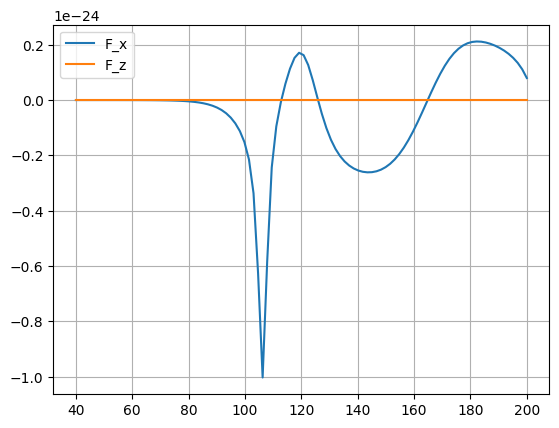

In [70]:
plt.plot(Rs, F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4], label='F_x')
plt.plot(Rs, F_y_from_R[:,0], label='F_z')
plt.grid()
plt.legend()